In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import torch

from tqdm import tqdm
from scipy import stats

from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker
from src.models import RecurrentSpaceNet

plt.style.use("figures/project_style.mplstyle")

In [2]:
save_loc = "figures" # location for saving figures

In [3]:
## Training parameters
train_steps = 30000
timesteps = 500
bs = 32 # batch size

# Model parameters
n_in = 2 # Cartesian coordinates, no context
n_out = 256 # no. of spatial representations

In [4]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in = n_in, n_out = n_out, corr_across_space= False, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [5]:
genny = SimpleDatasetMaker(rayleigh_scale=0.1) # use simple dataset

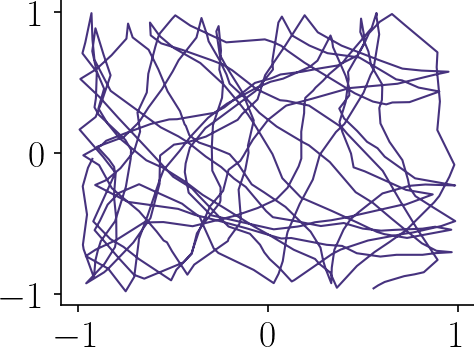

In [6]:
r, v = genny.generate_dataset(bs, timesteps, device = device)
plt.plot(r[0,:,0], r[0,:,1])

In [ ]:
train_history = []


progress = tqdm(range(train_steps))
for i in progress: # train loop
    optimizer.zero_grad()
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    labels = r[:,1:]
    loss = model.loss_fn(v, labels, hidden_state=None)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        train_history.append(loss.item())
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.010770:  73%|███████▎  | 21785/30000 [1:32:09<21:36,  6.34it/s]   

In [24]:
# torch.save(model, "./models/long_trajectory_rnn.pt")
# np.save("./models/long_trajectory_rnn_loss_history.npy", train_history)

Text(0, 0.5, 'Train Loss')

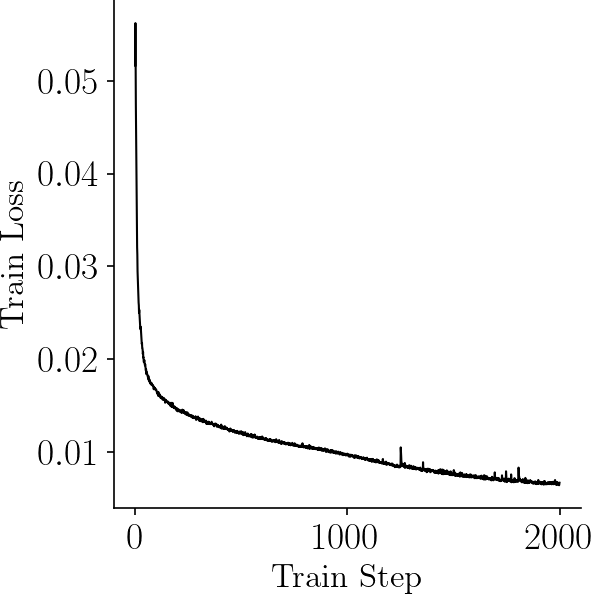

In [8]:
plt.figure(figsize=(4,4))
plt.plot(train_history, "-k")
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

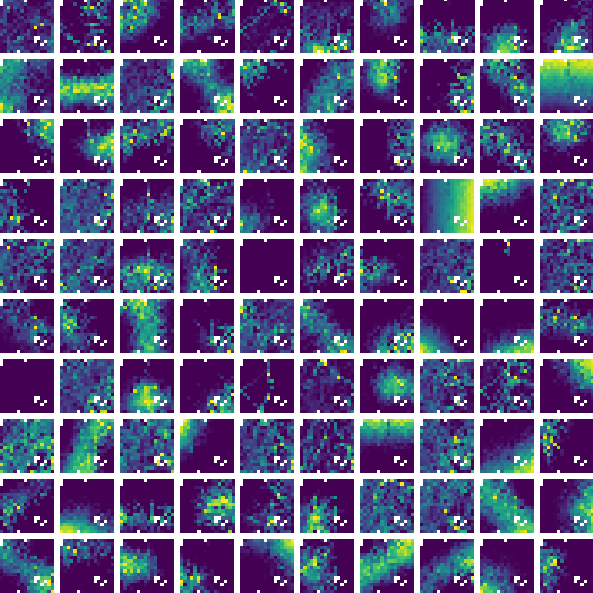

In [37]:
# visualize representations
n_plot = 1 # number of plot trajectories
n_show = 100 # number of units to show
eval_timesteps = 1000
r, v = genny.generate_dataset(n_plot, eval_timesteps)

bins = 16

# BSR 
_,p,_ = model(v, hidden_state = None)
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = bins)
fig, ax = ratemap_collage(ratemaps[:n_show], cols = int(np.sqrt(n_show)), figsize = (4,4))
# plt.savefig(f"{save_loc}/rnn_representations")

In [14]:
ratemaps.shape

(100, 16, 16)

(-0.5, 15.5, 15.5, -0.5)

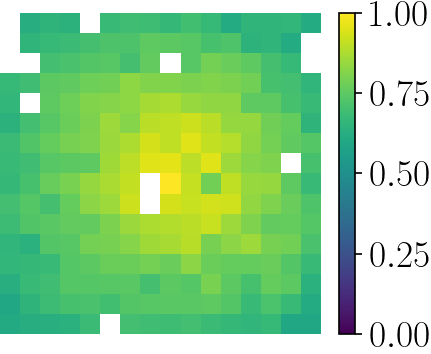

In [18]:
a = 8
sim = np.exp(-np.sum((ratemaps[:,a,a,None,None] - ratemaps)**2, axis = 0))
plt.imshow(sim.reshape(bins,bins), interpolation = "None", vmin = 0)
plt.colorbar()
plt.axis("off")